<a href="https://colab.research.google.com/github/lolek27/ML-entity_matching/blob/main/abt_buy_entity_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Read the data for Abt and Buy

In [4]:
import pandas as pd
import numpy as np

abt_buy_train_df = pd.read_csv("/content/drive/MyDrive/ML/data/abt_buy/gs_train.csv")
abt_buy_train_recs = abt_buy_train_df.to_dict('records')

abt_buy_val_df = pd.read_csv("/content/drive/MyDrive/ML/data/abt_buy/gs_val.csv")
abt_buy_val_recs = abt_buy_val_df.to_dict('records')

abt_buy_test_df = pd.read_csv("/content/drive/MyDrive/ML/data/abt_buy/gs_test.csv")
abt_buy_test_recs = abt_buy_test_df.to_dict('records')

abt_df = pd.read_csv("/content/drive/MyDrive/ML/data/abt_buy/1_abt.csv",  encoding = "ISO-8859-1")
abt_recs = abt_df.to_dict('records')

buy_df = pd.read_csv("/content/drive/MyDrive/ML/data/abt_buy/2_buy.csv",  encoding = "ISO-8859-1")
buy_recs = buy_df.to_dict('records')

abt_id_to_rec_map = {a['subject_id']: a for a in abt_recs}
buy_id_to_rec_map = {b['subject_id']: b for b in buy_recs}

len(abt_buy_train_recs), len(abt_buy_val_recs), len(abt_buy_test_recs), len(abt_recs), len(buy_recs)

(5010, 1439, 710, 1081, 1092)

In [3]:
abt_buy_train_df.head()

,source_id,target_id,matching
0,33161,207390654,False
1,36258,208085180,False
2,17417,90125786,False
3,34309,208504304,False
4,8060,90138537,False


In [4]:
abt_df.head()

,subject_id,name,description,price
0,552,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,NaN
1,580,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399.0
2,4696,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49.0
3,5644,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,NaN
4,6284,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158.0


In [6]:
buy_df.head()

,subject_id,name,description,manufacturer,price
0,10011646,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,LINKSYS,NaN
1,10140760,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,LINKSYS,NaN
2,10221960,Netgear ProSafe FS105 Ethernet Switch - FS105NA,NETGEAR FS105 Prosafe 5 Port 10/100 Desktop Sw...,Netgear,NaN
3,10246269,Belkin Pro Series High Integrity VGA/SVGA Moni...,1 x HD-15 - 1 x HD-15 - 10ft - Beige,Belkin,NaN
4,10315184,Netgear ProSafe JFS516 Ethernet Switch,Netgear ProSafe 16 Port 10/100 Rackmount Switc...,Netgear,NaN


##1.1 Data exploration

Positive to all-samples ratio for train, val and test:

In [ ]:
train_pos = len([a for a in abt_buy_train_recs if a['matching']])
val_pos = len([a for a in abt_buy_val_recs if a['matching']])
test_pos = len([a for a in abt_buy_test_recs if a['matching']])
train_pos, train_pos/len(abt_buy_train_recs), val_pos, val_pos/len(abt_buy_val_recs), test_pos, test_pos/len(abt_buy_test_recs)

(764, 0.15249500998003993, 220, 0.15288394718554552, 109, 0.15352112676056337)

Positive matches constitute about 15% of all data points

In [ ]:
len(abt_df[abt_df['price'].isnull()]) / len(abt_df), len(buy_df[buy_df['price'].isnull()]) / len(buy_df) 

(0.6133209990749307, 0.4597069597069597)

61% Abt records and 45% Buy recs lack price info

#2. Data Augmentation (used in 3.3)

In [ ]:
!pip install nlpaug transformers

In [13]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import random

aug_arr = []
aug_arr.append(naw.ContextualWordEmbsAug(aug_p = 0.1, action='substitute', top_k = 5, aug_min=0, aug_max = 3, stopwords=['name', 'product', 'description', 'price']))
aug_arr.append(naw.RandomWordAug(aug_p = 0.1, action='crop', aug_min=1, aug_max = 3))
aug_arr.append(naw.RandomWordAug(aug_p = 0.1, action='swap', aug_min=1, aug_max = 5, stopwords=['name', 'product', 'description', 'price']))
aug_arr.append(naw.RandomWordAug(aug_p = 0.1, action='delete', aug_min=1, aug_max = 4,  stopwords=['name', 'product', 'description', 'price']))
aug_arr.append( nac.RandomCharAug(aug_char_p=0.1, action='swap', aug_char_min =1, aug_char_max=5, include_numeric=False, stopwords=['name', 'product', 'description', 'price']))
aug_arr.append(nac.RandomCharAug(aug_char_p=0.1, action='delete', aug_char_min =1, aug_char_max=4, stopwords=['name', 'product', 'description', 'price']))
aug_arr.append(nac.RandomCharAug(aug_char_p=0.1, action='insert', aug_char_min =1, aug_char_max=4, include_numeric=False, stopwords=['name', 'product', 'description', 'price']))
aug_arr.append(nac.RandomCharAug(aug_char_p=0.1, action='substitute', aug_char_min =1, aug_char_max=4, include_numeric=False, stopwords=['name', 'product', 'description', 'price']))

pairs_pos_train = [(get_description(abt_id_to_rec_map[ab["source_id"]]), get_description(buy_id_to_rec_map[ab["target_id"]])) for ab in abt_buy_train_recs + abt_buy_val_recs if ab['matching']]
pairs_neg_train = [(get_description(abt_id_to_rec_map[ab["source_id"]]), get_description(buy_id_to_rec_map[ab["target_id"]])) for ab in abt_buy_train_recs + abt_buy_val_recs if not ab['matching']]

np.random.seed(42)


In [14]:
sent = 'War is old men talking and young men dying'
aug_arr[0].augment(sent)[0], aug_arr[2].augment(sent)[0]

('there is old men talking and young men dying',
 'War old is men talking and young men dying')

In [ ]:
def augment(d, col, aug_arr):
   # choose if this sample is going to be augmented - let's augment with prob 50%
   if np.random.rand() >= 0.5:
    ind = int(np.round(np.random.rand() * (len(aug_arr) - 1)))
    aug_sample = aug_arr[ind].augment(d[col])[0]
    return aug_sample
   return False

def augment_dataset(data):
  augmented_pos_train_data = []

  for d in data:
    d0 = False
    d1 = False

    augmented_pos_train_data.append(d)
    
    d0 = augment(d, 0, aug_arr)
    d1 = augment(d, 1, aug_arr)
    if not d0 and not d1:
      continue

    if d0 and d1:
      augmented_pos_train_data.append((d0, d1))
    else:
      if d0:
        d1 = d[1]
      else:
        d0 = d[0]
  
      augmented_pos_train_data.append((d0, d1))

  return augmented_pos_train_data

data_pos_aug = augment_dataset(pairs_pos_train)
data_neg_aug = augment_dataset(pairs_neg_train)

len(pairs_pos_train), len(data_pos_aug), len(pairs_neg_train), len(data_neg_aug)

(984, 1865, 5465, 10439)

In [ ]:
data_pos_aug[:6]

[('The name of the product is Samsung S2 White 1GB Flash MP3 Player - YPS2ZW. Description: Samsung S2 White 1GB Flash MP3 Player - YPS2ZW/ Super Compact Pebble Shape Design/ Supports MP3, WMA And Ogg/ 1 GB Internal Flash Memory/ Multi-Color LED Light Effects/ Embedded Easy-To-Use Playback Controls/ DNSe 2.0 Enabled/ USB Connection/ Up To 13 Hours Of Playback/ White Finish. The price is unknown.',
  'The name of the product is Samsung YP-S2ZW 1GB Flash MP3 Player - YP-S2ZW/XAA. Description: 1GB Flash Memory - White. The price is 29.67.'),
 ('The name of the product is Samsung S2 White 1GB Flash MP3 Player - YPS2ZW. Description: Samsung S2 WhTte 1GB Flash MP3 Player - YPSjZW / Tuper Compac+ Pebble Shape Design / SuppoJts MP3, WMA And Ogg / 1 GB Internal Flash MeTory / Milti - Color LED Light EffActs / Embedded Easy - To - Use Playback Controls / DNSe 2. 0 Enabled / USB Connectio& / Up To 13 Hours Of Playback / White Finish. The price is unknown.',
  'The name of the product is Samsnug YP

In [6]:
description_pos = data_pos_aug
description_neg = data_neg_aug

#3. Apply Sentence-Transformers embeddings + ScaNN Search

In [ ]:
def get_description(rec):
    price = 'unknown' if np.isnan(rec['price']) else rec['price']
    return f"The name of the product is {rec['name']}. Description: {rec['description']}. The price is {price}."

In [ ]:
!pip install sentence_transformers scann

In [ ]:
import Searcher from search

config = def_config = {
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
    'mappings': abt_buy_test_recs,
    'db_recs': abt_recs,
    'candidates_len': 10,
    'get_description': get_description
}
searcher = Searcher(config)

In [9]:
query_test_recs = [ buy_id_to_rec_map[a['target_id']] for a in abt_buy_test_recs]
searcher.encode_all(query_test_recs)
searcher.search()


In [19]:
searcher.get_description(abt_recs[0]), searcher.get_description(buy_recs[0])

('The name of the product is Sony Turntable - PSLX350H. Description: Sony Turntable - PSLX350H/ Belt Drive System/ 33-1/3 and 45 RPM Speeds/ Servo Speed Control/ Supplied Moving Magnet Phono Cartridge/ Bonded Diamond Stylus/ Static Balance Tonearm/ Pitch Control. The price is unknown.',
 'The name of the product is Linksys EtherFast EZXS88W Ethernet Switch - EZXS88W. Description: Linksys EtherFast 8-Port 10/100 Switch (New/Workgroup). The price is unknown.')

In [8]:
searcher.search()
len(searcher.db_embeddings), len(searcher.query_embeddings)

(1081, 710)

For pre-trained embeddings recall@1 is less than 68% and F1 score for positive class is about 72.9%

In [10]:
predictions = searcher.get_predictions_for_top_ks()
metrics_base = searcher.get_metrics(predictions)
metrics_base

[{'False': {'precision': 0.9431818181818182,
   'recall': 0.9667221297836939,
   'f1-score': 0.9548069022185702,
   'support': 601},
  'True': {'precision': 0.7872340425531915,
   'recall': 0.6788990825688074,
   'f1-score': 0.729064039408867,
   'support': 109},
  'accuracy': 0.9225352112676056,
  'macro avg': {'precision': 0.8652079303675049,
   'recall': 0.8228106061762506,
   'f1-score': 0.8419354708137186,
   'support': 710},
  'weighted avg': {'precision': 0.9192405399515079,
   'recall': 0.9225352112676056,
   'f1-score': 0.9201506035618693,
   'support': 710}},
 {'False': {'precision': 0.9644760213143873,
   'recall': 0.9034941763727121,
   'f1-score': 0.9329896907216495,
   'support': 601},
  'True': {'precision': 0.6054421768707483,
   'recall': 0.8165137614678899,
   'f1-score': 0.6953125,
   'support': 109},
  'accuracy': 0.8901408450704226,
  'macro avg': {'precision': 0.7849590990925678,
   'recall': 0.860003968920301,
   'f1-score': 0.8141510953608248,
   'support': 710}

In [ ]:
len(neighbors), len(distances)

(710, 710)

### Error analysis

The pretrained embeddings are not sensitive enough to subtle differences in model names, e.g. LCSX20 and LCSMX100

In [12]:
buy_test_recs = [ buy_id_to_rec_map[a['target_id']] for a in abt_buy_test_recs]
k = 1
wrongs_true1 = []
for i, p in enumerate(predictions):
  if abt_buy_test_recs[i]['matching'] and not p[str(k)]:
    wrongs_true1.append((i, buy_test_recs[i], abt_id_to_rec_map[abt_buy_test_recs[i]['source_id']], abt_recs[neighbors[i][0]])) #take first prediction
len(wrongs_true1), wrongs_true1[:3]

(35,
 [(2,
   {'subject_id': 207390682,
    'name': 'Sony LCS-X20 Camcorder Case - LCSX20',
    'description': 'Nylon, Polyamide - Black',
    'manufacturer': 'Sony',
    'price': nan},
   {'subject_id': 34036,
    'name': 'Sony Black Handycam Camcorder Soft Carrying Case - LCSX20',
    'description': 'Sony Black Handycam Camcorder Soft Carrying Case - LCSX20/ Compatible To Hard Drive And DVD Camcorders/ Stain Resistant Nylon/ Organizer For Accessories/ Shoulder Held Case',
    'price': nan},
   {'subject_id': 34150,
    'name': 'Sony Soft Camera Carrying Case - LCSMX100',
    'description': 'Sony Soft Camera Carrying Case - LCSMX100/ Stain Resistant Nylon/ Colored Interior/ Movable Partition/ Build-In Modular Interface/ Black Finish',
    'price': nan}),
  (12,
   {'subject_id': 90138537,
    'name': 'Panasonic KX-TSC14B Corded Telephone',
    'description': '2 x Phone Line(s) - Headset - Black',
    'manufacturer': 'Panasonic',
    'price': nan},
   {'subject_id': 30590,
    'name': 

##3.2 Fine-tune Sentence transformers on train + val pairs

### Multiple Negative Ranking Loss

In [ ]:
pairs_pos_train = [(abt_id_to_rec_map[ab["source_id"]], buy_id_to_rec_map[ab["target_id"]]) for ab in abt_buy_train_recs + abt_buy_val_recs if ab['matching']]
pairs_neg_train = [(abt_id_to_rec_map[ab["source_id"]], buy_id_to_rec_map[ab["target_id"]]) for ab in abt_buy_train_recs + abt_buy_val_recs if not ab['matching']]

description_pos = [(get_description(a), get_description(b)) for a, b in pairs_pos_train]
description_neg = [(get_description(a), get_description(b)) for a, b in pairs_neg_train]

In [ ]:
description_pos[0]

('The name of the product is Samsung S2 White 1GB Flash MP3 Player - YPS2ZW. Description: Samsung S2 White 1GB Flash MP3 Player - YPS2ZW/ Super Compact Pebble Shape Design/ Supports MP3, WMA And Ogg/ 1 GB Internal Flash Memory/ Multi-Color LED Light Effects/ Embedded Easy-To-Use Playback Controls/ DNSe 2.0 Enabled/ USB Connection/ Up To 13 Hours Of Playback/ White Finish. The price is unknown.',
 'The name of the product is Samsung YP-S2ZW 1GB Flash MP3 Player - YP-S2ZW/XAA. Description: 1GB Flash Memory - White. The price is 29.67.')

In [ ]:
import Searcher from search

config = def_config = {
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
    'mappings': abt_buy_test_recs,
    'db_recs': abt_recs,
    'candidates_len': 10,
    'get_description': get_description,
    'train': {
        'epochs': 40,
        'batch_size': 32,
        'loss': losses.MultipleNegativesRankingLoss
    }

}
searcher = Searcher(config)

In [ ]:
searcher.fine_tune_embeddings(description_pos)
searcher.search()

Fine-tunning embeddings improved the recall@1 by **~23% ** and positive class F1 score by almost **22%**!

In [ ]:
predictions = searcher.get_predictions_for_top_ks()
metrics_mnrl = searcher.get_metrics(predictions)

In [ ]:
metrics_mnrl

[{'False': {'precision': 0.9851973684210527,
   'recall': 0.9966722129783694,
   'f1-score': 0.9909015715467329,
   'support': 601},
  'True': {'precision': 0.9803921568627451,
   'recall': 0.9174311926605505,
   'f1-score': 0.9478672985781992,
   'support': 109},
  'accuracy': 0.9845070422535211,
  'macro avg': {'precision': 0.9827947626418989,
   'recall': 0.95705170281946,
   'f1-score': 0.9693844350624661,
   'support': 710},
  'weighted avg': {'precision': 0.9844596669282983,
   'recall': 0.9845070422535211,
   'f1-score': 0.9842949014712818,
   'support': 710}},
 {'False': {'precision': 0.9861830742659758,
   'recall': 0.9500831946755408,
   'f1-score': 0.9677966101694916,
   'support': 601},
  'True': {'precision': 0.7709923664122137,
   'recall': 0.926605504587156,
   'f1-score': 0.8416666666666667,
   'support': 109},
  'accuracy': 0.9464788732394366,
  'macro avg': {'precision': 0.8785877203390948,
   'recall': 0.9383443496313484,
   'f1-score': 0.9047316384180791,
   'suppor

##3.3 Fine-tune Sentence transformers on *augmented* train + val pairs

In [13]:
import Searcher from search

config = def_config = {
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
    'mappings': abt_buy_test_recs,
    'db_recs': abt_recs,
    'candidates_len': 10,
    'get_description': get_description,
    'train': {
        'epochs': 40,
        'batch_size': 16,
        'loss': losses.MultipleNegativesRankingLoss
    }

}
searcher = Searcher(config)


In [ ]:
# assing augmented data to positive & negative pairs before fine tuning
description_pos = data_pos_aug
description_neg = data_neg_aug

In [12]:
len(description_pos_aug)

1728

In [ ]:
searcher.fine_tune_embeddings(description_pos)
searcher.search()

Fine-tunning embeddings on augmented dataset improved the recall@1 by additional **~1% ** and positive class F1 score by almost **2%**!

In [19]:
predictions = searcher.get_predictions_for_top_ks()
metrics_mnrl_aug = searcher.get_metrics(predictions)
metrics_mnrl_aug

[{'False': {'precision': 0.9884868421052632,
   'recall': 1.0,
   'f1-score': 0.9942100909842845,
   'support': 601},
  'True': {'precision': 1.0,
   'recall': 0.9357798165137615,
   'f1-score': 0.966824644549763,
   'support': 109},
  'accuracy': 0.9901408450704225,
  'macro avg': {'precision': 0.9942434210526316,
   'recall': 0.9678899082568808,
   'f1-score': 0.9805173677670238,
   'support': 710},
  'weighted avg': {'precision': 0.9902543550778354,
   'recall': 0.9901408450704225,
   'f1-score': 0.9900058463908157,
   'support': 710}},
 {'False': {'precision': 0.9929824561403509,
   'recall': 0.9417637271214643,
   'f1-score': 0.9666951323654995,
   'support': 601},
  'True': {'precision': 0.75,
   'recall': 0.963302752293578,
   'f1-score': 0.8433734939759036,
   'support': 109},
  'accuracy': 0.9450704225352112,
  'macro avg': {'precision': 0.8714912280701754,
   'recall': 0.9525332397075211,
   'f1-score': 0.9050343131707015,
   'support': 710},
  'weighted avg': {'precision': 0

## Plot models

In [ ]:
metrics_tuned = [{'False': {'precision': 0.9851485148514851,
   'recall': 0.9933444259567388,
   'f1-score': 0.9892294946147473,
   'support': 601},
  'True': {'precision': 0.9615384615384616,
   'recall': 0.9174311926605505,
   'f1-score': 0.9389671361502349,
   'support': 109},
  'accuracy': 0.9816901408450704,
  'macro avg': {'precision': 0.9733434881949734,
   'recall': 0.9553878093086446,
   'f1-score': 0.9640983153824911,
   'support': 710},
  'weighted avg': {'precision': 0.9815238728639927,
   'recall': 0.9816901408450704,
   'f1-score': 0.9815131607096319,
   'support': 710}},
 {'False': {'precision': 0.986013986013986,
   'recall': 0.9384359400998337,
   'f1-score': 0.9616368286445013,
   'support': 601},
  'True': {'precision': 0.7318840579710145,
   'recall': 0.926605504587156,
   'f1-score': 0.8178137651821862,
   'support': 109},
  'accuracy': 0.9366197183098591,
  'macro avg': {'precision': 0.8589490219925002,
   'recall': 0.9325207223434948,
   'f1-score': 0.8897252969133438,
   'support': 710},
  'weighted avg': {'precision': 0.9469996731172483,
   'recall': 0.9366197183098591,
   'f1-score': 0.9395569498876106,
   'support': 710}},
 {'False': {'precision': 0.9906716417910447,
   'recall': 0.8835274542429284,
   'f1-score': 0.9340369393139841,
   'support': 601},
  'True': {'precision': 0.5977011494252874,
   'recall': 0.9541284403669725,
   'f1-score': 0.734982332155477,
   'support': 109},
  'accuracy': 0.8943661971830986,
  'macro avg': {'precision': 0.7941863956081661,
   'recall': 0.9188279473049505,
   'f1-score': 0.8345096357347306,
   'support': 710},
  'weighted avg': {'precision': 0.9303423690194003,
   'recall': 0.8943661971830986,
   'f1-score': 0.9034778517361288,
   'support': 710}},
 {'False': {'precision': 0.9903846153846154,
   'recall': 0.8569051580698835,
   'f1-score': 0.9188224799286352,
   'support': 601},
  'True': {'precision': 0.5473684210526316,
   'recall': 0.9541284403669725,
   'f1-score': 0.6956521739130436,
   'support': 109},
  'accuracy': 0.8718309859154929,
  'macro avg': {'precision': 0.7688765182186235,
   'recall': 0.9055167992184281,
   'f1-score': 0.8072373269208394,
   'support': 710},
  'weighted avg': {'precision': 0.9223722700575925,
   'recall': 0.8718309859154929,
   'f1-score': 0.8845611230896219,
   'support': 710}},
 {'False': {'precision': 0.9919678714859438,
   'recall': 0.8219633943427621,
   'f1-score': 0.8989990900818927,
   'support': 601},
  'True': {'precision': 0.49528301886792453,
   'recall': 0.963302752293578,
   'f1-score': 0.6542056074766356,
   'support': 109},
  'accuracy': 0.8436619718309859,
  'macro avg': {'precision': 0.7436254451769342,
   'recall': 0.89263307331817,
   'f1-score': 0.7766023487792642,
   'support': 710},
  'weighted avg': {'precision': 0.9157162532671211,
   'recall': 0.8436619718309859,
   'f1-score': 0.8614181188086912,
   'support': 710}},
 {'False': {'precision': 0.9915254237288136,
   'recall': 0.778702163061564,
   'f1-score': 0.8723205964585274,
   'support': 601},
  'True': {'precision': 0.4411764705882353,
   'recall': 0.963302752293578,
   'f1-score': 0.6051873198847262,
   'support': 109},
  'accuracy': 0.8070422535211268,
  'macro avg': {'precision': 0.7163509471585244,
   'recall': 0.871002457677571,
   'f1-score': 0.7387539581716268,
   'support': 710},
  'weighted avg': {'precision': 0.9070352323311754,
   'recall': 0.8070422535211268,
   'f1-score': 0.8313099948436762,
   'support': 710}},
 {'False': {'precision': 0.9935064935064936,
   'recall': 0.7637271214642263,
   'f1-score': 0.863593603010348,
   'support': 601},
  'True': {'precision': 0.4274193548387097,
   'recall': 0.9724770642201835,
   'f1-score': 0.5938375350140056,
   'support': 109},
  'accuracy': 0.795774647887324,
  'macro avg': {'precision': 0.7104629241726016,
   'recall': 0.868102092842205,
   'f1-score': 0.7287155690121768,
   'support': 710},
  'weighted avg': {'precision': 0.9066001581335521,
   'recall': 0.795774647887324,
   'f1-score': 0.8221803475010504,
   'support': 710}},
 {'False': {'precision': 0.9955156950672646,
   'recall': 0.7387687188019967,
   'f1-score': 0.8481375358166189,
   'support': 601},
  'True': {'precision': 0.4053030303030303,
   'recall': 0.981651376146789,
   'f1-score': 0.5737265415549597,
   'support': 109},
  'accuracy': 0.776056338028169,
  'macro avg': {'precision': 0.7004093626851474,
   'recall': 0.8602100474743928,
   'f1-score': 0.7109320386857894,
   'support': 710},
  'weighted avg': {'precision': 0.9049055817443045,
   'recall': 0.776056338028169,
   'f1-score': 0.8060096507820824,
   'support': 710}},
 {'False': {'precision': 0.9953271028037384,
   'recall': 0.7088186356073212,
   'f1-score': 0.8279883381924199,
   'support': 601},
  'True': {'precision': 0.37943262411347517,
   'recall': 0.981651376146789,
   'f1-score': 0.5473145780051151,
   'support': 109},
  'accuracy': 0.7507042253521127,
  'macro avg': {'precision': 0.6873798634586068,
   'recall': 0.845235005877055,
   'f1-score': 0.6876514580987675,
   'support': 710},
  'weighted avg': {'precision': 0.9007742884695994,
   'recall': 0.7507042253521127,
   'f1-score': 0.7848989862763407,
   'support': 710}},
 {'False': {'precision': 0.9951923076923077,
   'recall': 0.6888519134775375,
   'f1-score': 0.8141592920353983,
   'support': 601},
  'True': {'precision': 0.36394557823129253,
   'recall': 0.981651376146789,
   'f1-score': 0.5310173697270472,
   'support': 109},
  'accuracy': 0.7338028169014085,
  'macro avg': {'precision': 0.6795689429618001,
   'recall': 0.8352516448121632,
   'f1-score': 0.6725883308812227,
   'support': 710},
  'weighted avg': {'precision': 0.898282598521532,
   'recall': 0.7338028169014085,
   'f1-score': 0.7706910250894683,
   'support': 710}}]

metrics_tuned_aug = [{'False': {'precision': 0.9884868421052632,
   'recall': 1.0,
   'f1-score': 0.9942100909842845,
   'support': 601},
  'True': {'precision': 1.0,
   'recall': 0.9357798165137615,
   'f1-score': 0.966824644549763,
   'support': 109},
  'accuracy': 0.9901408450704225,
  'macro avg': {'precision': 0.9942434210526316,
   'recall': 0.9678899082568808,
   'f1-score': 0.9805173677670238,
   'support': 710},
  'weighted avg': {'precision': 0.9902543550778354,
   'recall': 0.9901408450704225,
   'f1-score': 0.9900058463908157,
   'support': 710}},
 {'False': {'precision': 0.9929824561403509,
   'recall': 0.9417637271214643,
   'f1-score': 0.9666951323654995,
   'support': 601},
  'True': {'precision': 0.75,
   'recall': 0.963302752293578,
   'f1-score': 0.8433734939759036,
   'support': 109},
  'accuracy': 0.9450704225352112,
  'macro avg': {'precision': 0.8714912280701754,
   'recall': 0.9525332397075211,
   'f1-score': 0.9050343131707015,
   'support': 710},
  'weighted avg': {'precision': 0.955679515690635,
   'recall': 0.9450704225352112,
   'f1-score': 0.9477626554859699,
   'support': 710}},
 {'False': {'precision': 0.994392523364486,
   'recall': 0.8851913477537438,
   'f1-score': 0.9366197183098592,
   'support': 601},
  'True': {'precision': 0.6057142857142858,
   'recall': 0.9724770642201835,
   'f1-score': 0.7464788732394366,
   'support': 109},
  'accuracy': 0.8985915492957747,
  'macro avg': {'precision': 0.8000534045393859,
   'recall': 0.9288342059869636,
   'f1-score': 0.841549295774648,
   'support': 710},
  'weighted avg': {'precision': 0.9347222023731172,
   'recall': 0.8985915492957747,
   'f1-score': 0.9074290815314423,
   'support': 710}},
 {'False': {'precision': 0.9980694980694981,
   'recall': 0.8602329450915142,
   'f1-score': 0.9240393208221627,
   'support': 601},
  'True': {'precision': 0.5625,
   'recall': 0.9908256880733946,
   'f1-score': 0.717607973421927,
   'support': 109},
  'accuracy': 0.8802816901408451,
  'macro avg': {'precision': 0.7802847490347491,
   'recall': 0.9255293165824543,
   'f1-score': 0.8208236471220448,
   'support': 710},
  'weighted avg': {'precision': 0.9312003779433358,
   'recall': 0.8802816901408451,
   'f1-score': 0.892347747770577,
   'support': 710}},
 {'False': {'precision': 1.0,
   'recall': 0.8352745424292846,
   'f1-score': 0.9102447869446962,
   'support': 601},
  'True': {'precision': 0.5240384615384616,
   'recall': 1.0,
   'f1-score': 0.6876971608832807,
   'support': 109},
  'accuracy': 0.8605633802816901,
  'macro avg': {'precision': 0.7620192307692308,
   'recall': 0.9176372712146423,
   'f1-score': 0.7989709739139885,
   'support': 710},
  'weighted avg': {'precision': 0.9269298483206934,
   'recall': 0.8605633802816901,
   'f1-score': 0.8760790246338593,
   'support': 710}},
 {'False': {'precision': 1.0,
   'recall': 0.800332778702163,
   'f1-score': 0.8890942698706099,
   'support': 601},
  'True': {'precision': 0.4759825327510917,
   'recall': 1.0,
   'f1-score': 0.6449704142011834,
   'support': 109},
  'accuracy': 0.8309859154929577,
  'macro avg': {'precision': 0.7379912663755459,
   'recall': 0.9001663893510815,
   'f1-score': 0.7670323420358967,
   'support': 710},
  'weighted avg': {'precision': 0.919552247985731,
   'recall': 0.8309859154929577,
   'f1-score': 0.8516161004791064,
   'support': 710}},
 {'False': {'precision': 1.0,
   'recall': 0.778702163061564,
   'f1-score': 0.8755846585594013,
   'support': 601},
  'True': {'precision': 0.45041322314049587,
   'recall': 1.0,
   'f1-score': 0.6210826210826211,
   'support': 109},
  'accuracy': 0.8126760563380282,
  'macro avg': {'precision': 0.7252066115702479,
   'recall': 0.889351081530782,
   'f1-score': 0.7483336398210112,
   'support': 710},
  'weighted avg': {'precision': 0.9156268187638226,
   'recall': 0.8126760563380282,
   'f1-score': 0.8365132190031068,
   'support': 710}},
 {'False': {'precision': 1.0,
   'recall': 0.7537437603993344,
   'f1-score': 0.8595825426944972,
   'support': 601},
  'True': {'precision': 0.42412451361867703,
   'recall': 1.0,
   'f1-score': 0.5956284153005464,
   'support': 109},
  'accuracy': 0.7915492957746478,
  'macro avg': {'precision': 0.7120622568093385,
   'recall': 0.8768718801996672,
   'f1-score': 0.7276054789975218,
   'support': 710},
  'weighted avg': {'precision': 0.9115909464569518,
   'recall': 0.7915492957746478,
   'f1-score': 0.8190600076438765,
   'support': 710}},
 {'False': {'precision': 1.0,
   'recall': 0.7420965058236273,
   'f1-score': 0.8519579751671442,
   'support': 601},
  'True': {'precision': 0.4128787878787879,
   'recall': 1.0,
   'f1-score': 0.5844504021447722,
   'support': 109},
  'accuracy': 0.7816901408450704,
  'macro avg': {'precision': 0.7064393939393939,
   'recall': 0.8710482529118136,
   'f1-score': 0.7182041886559583,
   'support': 710},
  'weighted avg': {'precision': 0.9098644899701238,
   'recall': 0.7816901408450704,
   'f1-score': 0.8108899111397659,
   'support': 710}},
 {'False': {'precision': 1.0,
   'recall': 0.7321131447587355,
   'f1-score': 0.8453410182516811,
   'support': 601},
  'True': {'precision': 0.40370370370370373,
   'recall': 1.0,
   'f1-score': 0.575197889182058,
   'support': 109},
  'accuracy': 0.7732394366197183,
  'macro avg': {'precision': 0.7018518518518518,
   'recall': 0.8660565723793677,
   'f1-score': 0.7102694537168696,
   'support': 710},
  'weighted avg': {'precision': 0.9084559207094418,
   'recall': 0.7732394366197183,
   'f1-score': 0.8038683406902882,
   'support': 710}}]



metrics_base = [{'False': {'precision': 0.9431818181818182,
   'recall': 0.9667221297836939,
   'f1-score': 0.9548069022185702,
   'support': 601},
  'True': {'precision': 0.7872340425531915,
   'recall': 0.6788990825688074,
   'f1-score': 0.729064039408867,
   'support': 109},
  'accuracy': 0.9225352112676056,
  'macro avg': {'precision': 0.8652079303675049,
   'recall': 0.8228106061762506,
   'f1-score': 0.8419354708137186,
   'support': 710},
  'weighted avg': {'precision': 0.9192405399515079,
   'recall': 0.9225352112676056,
   'f1-score': 0.9201506035618693,
   'support': 710}},
 {'False': {'precision': 0.9644760213143873,
   'recall': 0.9034941763727121,
   'f1-score': 0.9329896907216495,
   'support': 601},
  'True': {'precision': 0.6054421768707483,
   'recall': 0.8165137614678899,
   'f1-score': 0.6953125,
   'support': 109},
  'accuracy': 0.8901408450704226,
  'macro avg': {'precision': 0.7849590990925678,
   'recall': 0.860003968920301,
   'f1-score': 0.8141510953608248,
   'support': 710},
  'weighted avg': {'precision': 0.909356740970223,
   'recall': 0.8901408450704226,
   'f1-score': 0.8965012205967765,
   'support': 710}},
 {'False': {'precision': 0.9679245283018868,
   'recall': 0.8535773710482529,
   'f1-score': 0.907161803713528,
   'support': 601},
  'True': {'precision': 0.5111111111111111,
   'recall': 0.8440366972477065,
   'f1-score': 0.6366782006920415,
   'support': 109},
  'accuracy': 0.852112676056338,
  'macro avg': {'precision': 0.7395178197064989,
   'recall': 0.8488070341479796,
   'f1-score': 0.7719200022027848,
   'support': 710},
  'weighted avg': {'precision': 0.8977940177754156,
   'recall': 0.852112676056338,
   'f1-score': 0.8656368562074124,
   'support': 710}},
 {'False': {'precision': 0.9744094488188977,
   'recall': 0.8236272878535774,
   'f1-score': 0.8926961226330027,
   'support': 601},
  'True': {'precision': 0.4752475247524752,
   'recall': 0.8807339449541285,
   'f1-score': 0.6173633440514469,
   'support': 109},
  'accuracy': 0.8323943661971831,
  'macro avg': {'precision': 0.7248284867856865,
   'recall': 0.852180616403853,
   'f1-score': 0.7550297333422248,
   'support': 710},
  'weighted avg': {'precision': 0.8977775478002498,
   'recall': 0.8323943661971831,
   'f1-score': 0.8504267242310454,
   'support': 710}},
 {'False': {'precision': 0.979253112033195,
   'recall': 0.7853577371048253,
   'f1-score': 0.8716528162511542,
   'support': 601},
  'True': {'precision': 0.4342105263157895,
   'recall': 0.908256880733945,
   'f1-score': 0.5875370919881305,
   'support': 109},
  'accuracy': 0.8042253521126761,
  'macro avg': {'precision': 0.7067318191744922,
   'recall': 0.846807308919385,
   'f1-score': 0.7295949541196424,
   'support': 710},
  'weighted avg': {'precision': 0.8955775601413679,
   'recall': 0.8042253521126761,
   'f1-score': 0.8280350501319012,
   'support': 710}},
 {'False': {'precision': 0.9806034482758621,
   'recall': 0.757071547420965,
   'f1-score': 0.8544600938967136,
   'support': 601},
  'True': {'precision': 0.4065040650406504,
   'recall': 0.9174311926605505,
   'f1-score': 0.5633802816901409,
   'support': 109},
  'accuracy': 0.7816901408450704,
  'macro avg': {'precision': 0.6935537566582562,
   'recall': 0.8372513700407578,
   'f1-score': 0.7089201877934272,
   'support': 710},
  'weighted avg': {'precision': 0.8924670640890479,
   'recall': 0.7816901408450704,
   'f1-score': 0.8097731931495075,
   'support': 710}},
 {'False': {'precision': 0.9865470852017937,
   'recall': 0.7321131447587355,
   'f1-score': 0.8404966571155683,
   'support': 601},
  'True': {'precision': 0.39015151515151514,
   'recall': 0.944954128440367,
   'f1-score': 0.5522788203753352,
   'support': 109},
  'accuracy': 0.7647887323943662,
  'macro avg': {'precision': 0.6883493001766544,
   'recall': 0.8385336365995513,
   'f1-score': 0.6963877387454518,
   'support': 710},
  'weighted avg': {'precision': 0.8949877652926663,
   'recall': 0.7647887323943662,
   'f1-score': 0.7962491300667155,
   'support': 710}},
 {'False': {'precision': 0.990521327014218,
   'recall': 0.6955074875207987,
   'f1-score': 0.8172043010752689,
   'support': 601},
  'True': {'precision': 0.3645833333333333,
   'recall': 0.963302752293578,
   'f1-score': 0.5289672544080605,
   'support': 109},
  'accuracy': 0.7366197183098592,
  'macro avg': {'precision': 0.6775523301737757,
   'recall': 0.8294051199071883,
   'f1-score': 0.6730857777416647,
   'support': 710},
  'weighted avg': {'precision': 0.8944266209420823,
   'recall': 0.7366197183098592,
   'f1-score': 0.7729538248967819,
   'support': 710}},
 {'False': {'precision': 0.9924050632911392,
   'recall': 0.6522462562396006,
   'f1-score': 0.7871485943775101,
   'support': 601},
  'True': {'precision': 0.33650793650793653,
   'recall': 0.9724770642201835,
   'f1-score': 0.5,
   'support': 109},
  'accuracy': 0.7014084507042253,
  'macro avg': {'precision': 0.6644564998995379,
   'recall': 0.8123616602298921,
   'f1-score': 0.643574297188755,
   'support': 710},
  'weighted avg': {'precision': 0.8917109973483659,
   'recall': 0.7014084507042253,
   'f1-score': 0.7430652186209628,
   'support': 710}},
 {'False': {'precision': 0.9920844327176781,
   'recall': 0.6256239600665557,
   'f1-score': 0.7673469387755102,
   'support': 601},
  'True': {'precision': 0.3202416918429003,
   'recall': 0.9724770642201835,
   'f1-score': 0.4818181818181818,
   'support': 109},
  'accuracy': 0.6788732394366197,
  'macro avg': {'precision': 0.6561630622802892,
   'recall': 0.7990505121433696,
   'f1-score': 0.624582560296846,
   'support': 710},
  'weighted avg': {'precision': 0.888942378132677,
   'recall': 0.6788732394366197,
   'f1-score': 0.7235122422848781,
   'support': 710}}]

r_pos_tuned = [m['True']['recall'] for m in metrics_tuned]
r_neg_tuned = [m['False']['recall'] for m in metrics_tuned]
f1_tuned = [m['macro avg']['f1-score'] for m in metrics_tuned]

r_pos_aug = [m['True']['recall'] for m in metrics_tuned_aug]
r_neg_aug = [m['False']['recall'] for m in metrics_tuned_aug]
f1_aug = [m['macro avg']['f1-score'] for m in metrics_tuned_aug]

r_pos_base = [m['True']['recall'] for m in metrics_base]
r_neg_base = [m['False']['recall'] for m in metrics_base]
f1_base = [m['macro avg']['f1-score']for m in metrics_base]

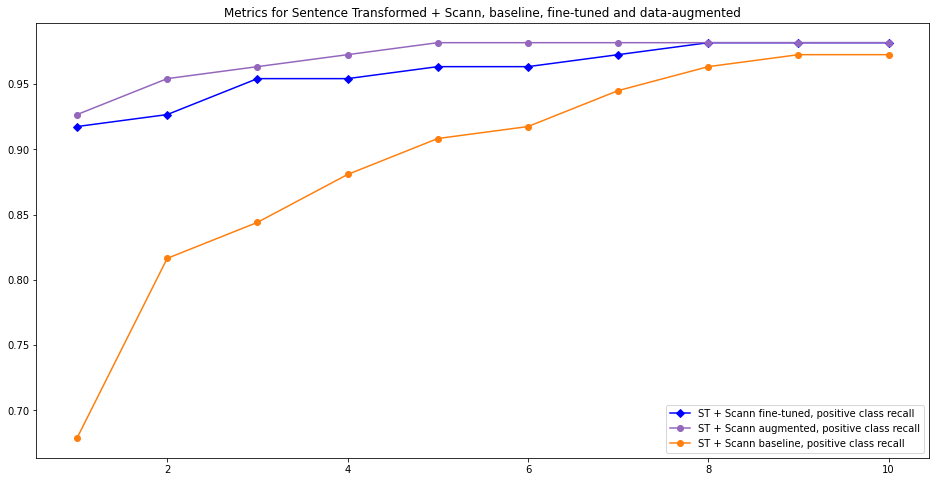

In [ ]:
import matplotlib.pyplot  as plt
import numpy as np


x = range(1, 11)

plt.plot(x, r_pos_tuned, '-bD',  label='ST + Scann fine-tuned, positive class recall')
# plt.plot(x, r_neg_tuned, '-C0D',  label='ST + Scann fine-tuned, negative class recall')
# plt.plot(x, f1_tuned, '-C2D',  label='ST + Scann fine-tuned, macro avg F1')

plt.plot(x, r_pos_aug, '-C4o',  label='ST + Scann augmented, positive class recall')
# plt.plot(x, r_neg_aug, '-C6o',  label='ST + Scann augmented, negative class recall')
# plt.plot(x, f1_aug, '-mo',  label='ST + Scann augmented, macro avg class F1')

plt.plot(x, r_pos_base, '-C1o',  label='ST + Scann baseline, positive class recall')
# plt.plot(x, r_neg_base, '-C3o',  label='ST + Scann baseline, negative class recall')
# plt.plot(x, f1_base, '-C8o',  label='ST + Scann baseline, macro avg class F1')

plt.legend()
plt.title('Metrics for Sentence Transformed + Scann, baseline, fine-tuned and data-augmented')
# plotting a line plot after changing it's width and height
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

